# Introduction to Deep Dreaming

Deep Dreaming is a fascinating computer vision technique that uses neural networks to generate dream-like images by enhancing patterns the network detects.

## What is Deep Dreaming?

Deep Dreaming was introduced by Google in 2015. It works by:
1. Taking a pre-trained convolutional neural network (usually trained on ImageNet)
2. Choosing specific layers to enhance
3. Maximizing the activations of those layers through gradient ascent
4. Applying the process iteratively to create increasingly psychedelic images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F # for jitter we need this
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration - Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


When loading new model. We can print all layers` names so it is easy to select layers for Deep Dreaming.

In [3]:
# Load pre-trained GoogLeNet (Inception v1) model
# GoogLeNet is particularly good for DeepDream due to its inception modules
model = models.googlenet(pretrained=True).to(device)
# model = models.inception_v3(pretrained=True).to(device)
# Set model to evaluation mode to disable training-specific operations like dropout
model.eval()

# Print model architecture for debugging and layer inspection
print("Model architecture:")
print(model)

# List all layer names to help with selecting layers for enhancement
print("\nModel layers:")
for name, module in model.named_modules():
    print(name, end=" ")

# Freeze all model parameters since we'll only be modifying the input image
for param in model.parameters():
    param.requires_grad = False

Model architecture:

D:\Other\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Other\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, trac

Let's choose initial image, model layers and image generation parameters.

In [4]:
# image_path = 'images/breaking-bad.jpg'  # Replace with your image path
image_path = 'images/Donald-Trump-2.jpg'  # Replace with your image path
# image_path = 'images/rambo.jpg'  # Replace with your image path
# image_path = 'images/chicago.jpg'  # Replace with your image path
# image_path = 'images/forest.jpg'  # Replace with your image path


# Parameters for the dream effect
iterations = 50  # Number of optimization steps
lr = 0.01       # Learning rate
# lr = 0.05       # Learning rate

# Parameters for multi-scale processing
num_octaves = 5        # Number of scales to process
octave_scale = 1.4    # Scaling factor between octaves

# Define which layers to enhance and their weights
# Higher weights mean stronger enhancement effects from that layer
# inception4a-e are different depths of the network:
# - Earlier layers (4a, 4b) capture simpler features
# - Later layers (4c, 4d, 4e) capture more complex features
layer_names_weights = {
    'inception4a': 1.0,
    # 'inception4b': 1.0,
    # 'inception4c': 1.0,
    # 'inception4d': 1.0,
    # 'inception4e': 1.0,
}

# layer_names_weights = {
#     # 'Mixed_5b': 1.0,
#     # 'Mixed_5c': 1.0,
#     # 'Mixed_5d': 1.0,
#     'Mixed_6a': 4.0,
#     'Mixed_6b': 4.0,
#     'Mixed_6c': 4.0,
#     # 'Mixed_6d': 2.0,
#     # 'Mixed_6e': 2.0,
#     # 'Mixed_7a': 4.0,
#     # 'Mixed_7b': 4.0,
#     # 'Mixed_7c': 4.0,
# }

In [5]:
# Define image preprocessing pipeline
# These transformations prepare the image for the model:
# 1. Convert to tensor (ToTensor)
# 2. Normalize using ImageNet statistics (what GoogLeNet was trained on)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [6]:
# Function to convert processed tensor back to displayable image
def deprocess(image_tensor):
    image = image_tensor.clone().detach().cpu()
    # Reverse the normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image * std + mean
    # Ensure pixel values are in valid range [0,1]
    image = image.clamp(0,1)
    image = image.squeeze(0)  # Remove batch dimension
    image = image.permute(1,2,0)  # C x H x W => H x W x C
    return image.numpy()

In [7]:
# Calculate total variation loss to ensure smoothness in the generated image
# This helps reduce high-frequency artifacts and noise
def total_variation_loss(img):
    # Calculate differences between adjacent pixels horizontally and vertically
    tv_loss = torch.sum(torch.abs(img[:, :, :-1] - img[:, :, 1:])) + \
              torch.sum(torch.abs(img[:, :-1, :] - img[:, 1:, :]))
    return tv_loss

In [8]:
def add_random_jitter(image, jitter=32):
    """
    Add random jitter to image by padding and random cropping.
    
    Args:
        image: Input tensor image (B, C, H, W)
        jitter: Maximum number of pixels to jitter by
    Returns:
        Jittered image and the jitter amounts for undoing
    """
    b, c, h, w = image.shape
    
    # Pad the image with reflect padding
    padded = F.pad(image, (jitter, jitter, jitter, jitter), mode='reflect')
    
    # Generate random crop coordinates
    dx = torch.randint(0, jitter * 2, (1,))
    dy = torch.randint(0, jitter * 2, (1,))
    
    # Crop the image at the random offset
    jittered = padded[:, :, dy:dy + h, dx:dx + w]
    
    return jittered, (dx, dy)

def remove_jitter(image, jitter_amounts, orig_shape):
    """
    Remove the jitter from the image by cropping back to original position.
    
    Args:
        image: Jittered image tensor
        jitter_amounts: Tuple of (dx, dy) jitter amounts
        orig_shape: Original shape of image before jitter
    Returns:
        Unjittered image
    """
    dx, dy = jitter_amounts
    h, w = orig_shape[-2:]
    return image[:, :, :h, :w]

In [9]:
# Modified deep_dream function with jitter
def deep_dream_with_jitter(model, image, iterations, lr, layer_names_weights, optimizer_name='Adam', tv_weight=0.0000001, jitter=32):
    """
    Generate DeepDream effect with random jitter to prevent artifacts.
    
    Args:
        model: Pre-trained neural network
        image: Input image tensor
        iterations: Number of optimization steps
        lr: Learning rate
        layer_names_weights: Dictionary of layer names and their weights for enhancement
        optimizer_name: Optimization algorithm to use
        tv_weight: Weight of total variation loss
        jitter: Maximum number of pixels to jitter by
    """
    orig_shape = image.shape
    image = image.clone().requires_grad_(True).to(device)

    activations = {}
    hooks = []

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    for name, module in model.named_modules():
        if name in layer_names_weights:
            hooks.append(module.register_forward_hook(get_activation(name)))

    if optimizer_name == 'Adam':
        optimizer = optim.Adam([image], lr=lr)
        use_closure = False
    elif optimizer_name == 'LBFGS':
        optimizer = optim.LBFGS([image], lr=lr, max_iter=iterations)
        use_closure = True
    else:
        optimizer = optim.SGD([image], lr=lr, momentum=0.9)
        use_closure = False

    if use_closure:
        iteration = [0]

        def closure():
            optimizer.zero_grad()
            activations.clear()
            
            # Add jitter
            jittered_image, jitter_amounts = add_random_jitter(image, jitter)
            
            out = model(jittered_image)
            losses = []
            for name in layer_names_weights:
                if name in activations:
                    weight = layer_names_weights[name]
                    # activation = activations[name]
                    activation = activations[name] ** 2
                    # losses.append(-weight * activation.norm())
                    losses.append(-weight * activation.mean())
            
            dream_loss = sum(losses)
            tv_loss = total_variation_loss(jittered_image[0])
            loss = dream_loss + tv_weight * tv_loss
            
            loss.backward()
            
            # Remove jitter from gradients
            if image.grad is not None:
                image.grad.data = remove_jitter(image.grad.data, jitter_amounts, orig_shape)

            if iteration[0] % 10 == 0:
                print(f"Iteration {iteration[0]}, Loss: {loss.item()}")

            iteration[0] += 1
            return loss

        optimizer.step(closure)
        image.data.clamp_(-1.5, 1.5)

    else:
        for i in range(iterations):
            optimizer.zero_grad()
            activations.clear()
            
            # Add jitter
            jittered_image, jitter_amounts = add_random_jitter(image, jitter)
            
            out = model(jittered_image)
            
            losses = []
            for name in layer_names_weights:
                if name in activations:
                    weight = layer_names_weights[name]
                    # activation = activations[name]
                    activation = activations[name] ** 2
                    # losses.append(-weight * activation.norm())
                    losses.append(-weight * activation.mean())
            
            dream_loss = sum(losses)
            tv_loss = total_variation_loss(jittered_image[0])
            loss = dream_loss + tv_weight * tv_loss
            
            loss.backward()
            
            # Remove jitter from gradients
            if image.grad is not None:
                image.grad.data = remove_jitter(image.grad.data, jitter_amounts, orig_shape)
            
            optimizer.step()
            image.data.clamp_(-1.5, 1.5)

            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {loss.item()}")

    for hook in hooks:
        hook.remove()

    return image.detach()

In [10]:
# Update the multiscale function to use jitter
def deep_dream_multiscale_with_jitter(model, base_image, iterations, lr, layer_names_weights, 
                                    num_octaves, octave_scale, optimizer_name='Adam', jitter=32):
    image = base_image.clone()
    octaves = []

    for i in range(num_octaves):
        scale_factor = octave_scale ** (-i)
        size = [int(dim * scale_factor) for dim in image.shape[-2:]]
        octave_image = nn.functional.interpolate(image, size=size, mode='bilinear', align_corners=False)
        octaves.append(octave_image)
    
    detail = torch.zeros_like(octaves[-1], device=device)

    for octave, octave_image in enumerate(reversed(octaves)):
        print(f"Processing octave {num_octaves - octave}")
        if detail.shape != octave_image.shape:
            detail = nn.functional.interpolate(detail, size=octave_image.shape[-2:], 
                                            mode='bilinear', align_corners=False)
        input_image = octave_image + detail
        
        # Use the jittered version of deep dream
        dreamed_image = deep_dream_with_jitter(model, input_image, iterations, lr, 
                                             layer_names_weights, optimizer_name, 
                                             jitter=max(int(jitter * octave_scale**(-octave)), 8))
        detail = dreamed_image - octave_image

    return dreamed_image

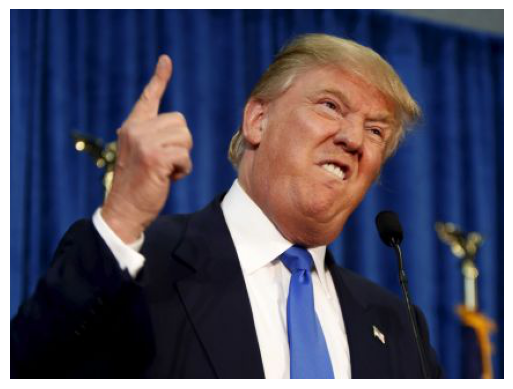

Processing octave 5
Iteration 0, Loss: -0.492160439491272
Iteration 10, Loss: -0.6186424493789673
Iteration 20, Loss: -0.7478755116462708
Iteration 30, Loss: -0.7569358944892883
Iteration 40, Loss: -0.8463984131813049
Processing octave 4
Iteration 0, Loss: -0.6184744238853455
Iteration 10, Loss: -0.7509000897407532
Iteration 20, Loss: -0.8641533851623535
Iteration 30, Loss: -0.9955209493637085
Iteration 40, Loss: -1.0481977462768555
Processing octave 3
Iteration 0, Loss: -0.6661100387573242
Iteration 10, Loss: -0.8246208429336548
Iteration 20, Loss: -0.9695878028869629
Iteration 30, Loss: -1.0872231721878052
Iteration 40, Loss: -1.1386419534683228
Processing octave 2
Iteration 0, Loss: -0.6590452790260315
Iteration 10, Loss: -0.8815346360206604
Iteration 20, Loss: -0.9920193552970886
Iteration 30, Loss: -1.069801688194275
Iteration 40, Loss: -1.2612299919128418
Processing octave 1
Iteration 0, Loss: -0.6753438711166382
Iteration 10, Loss: -0.8716297745704651
Iteration 20, Loss: -1.0079

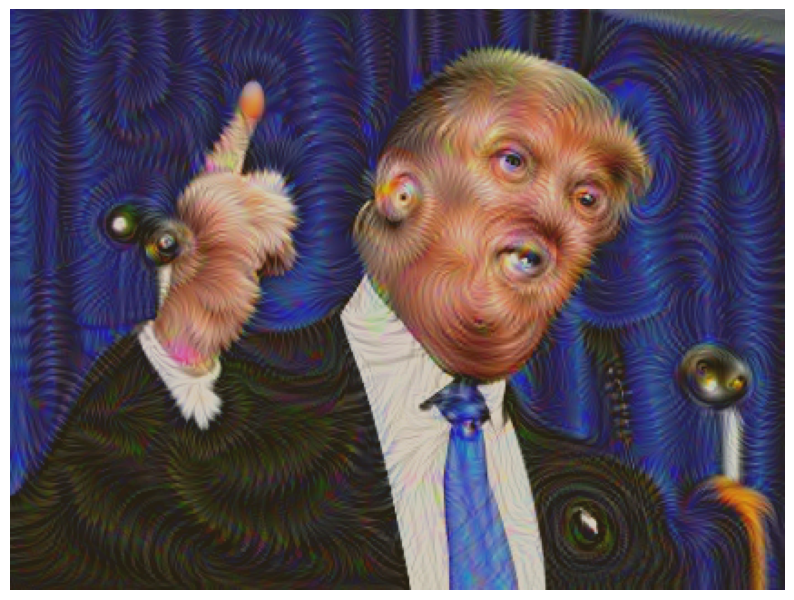

In [11]:
# Load and display input image
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess image for model input
input_image = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate the DeepDream effect
# dreamed_image = deep_dream_multiscale(model, input_image, iterations, lr, layer_names_weights, num_octaves, octave_scale, optimizer_name='Adam')
dreamed_image = deep_dream_multiscale_with_jitter(model, input_image, iterations, lr, layer_names_weights, num_octaves, octave_scale, optimizer_name='Adam')

# Display the final result
result = deprocess(dreamed_image)
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis('off')
plt.show()

## Understanding the Results

The resulting images will show enhanced patterns that the neural network has learned to recognize. Common effects include:
- Dog/bird-like features appearing in clouds or textures
- Enhancement of edges and patterns
- Dream-like swirls and repetitions
- Emergence of eyes and other organic shapes

## Tips for Better Results

1. Try different layers of the network:
   - Earlier layers produce finer, more detailed patterns
   - Deeper layers create larger, more abstract features

2. Adjust the step size:
   - Larger steps create more dramatic changes
   - Smaller steps preserve more of the original image

4. Experiment with octaves:
   - Processing the image at different scales can create more interesting results
   - Each octave can have different numbers of steps

## Advanced Techniques

For more advanced implementations, consider:
1. Implementing octave scaling (already implemented)
2. Adding random jitter to avoid artifacts (already implemented)
3. Using different models (VGG, ResNet, etc.) (compared to vgg, googlenet gave much nicer results)
4. Targeting specific channels or neurons
5. Combining with style transfer techniques

Deep Dreaming is both an artistic tool and a way to visualize what neural networks have learned. The results can provide insights into how these networks process and understand images.